# Melanoma Detection with the ResNeSt Model

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


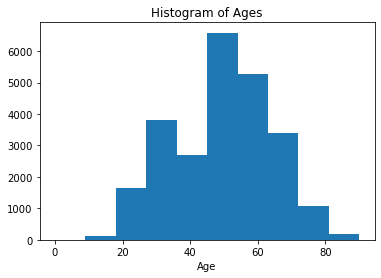

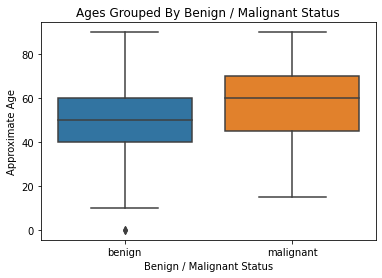

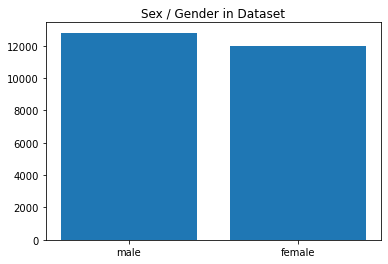

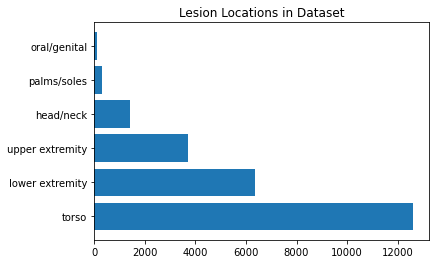

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



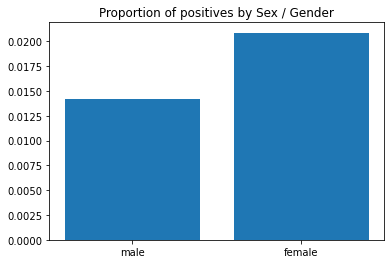



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



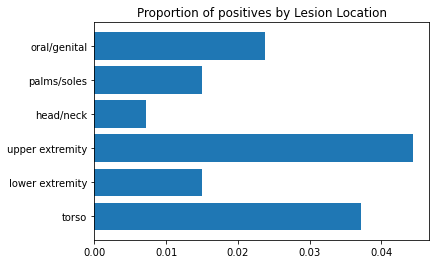

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## ResNet-50 (Feature Extraction)

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 2


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
        
        image_list.append(torch.unsqueeze(_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 4

tr_transf = transforms.Compose(
    [transforms.Resize(416),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Resize(416),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "train.csv"), 
                            num_samples=5*2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [9]:
load_weights = False
create_new_weights = True
PATH = './melanoma_ResNeSt.pth'

# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

if load_weights:
    print('Loading the pre-trained ResNeSt weights.')
    
    # network weights load
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 1024),
               nn.BatchNorm1d(1024),
               nn.ReLU(),
               nn.Dropout(p=0.4),
               nn.Linear(1024, 256),
               nn.BatchNorm1d(256),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(256, 1),
               nn.Sigmoid()).to(device)

    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=12204, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new ResNeSt FC Layer weights.')
    
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 1024),
               nn.BatchNorm1d(1024),
               nn.ReLU(),
               nn.Dropout(p=0.4),
               nn.Linear(1024, 256),
               nn.BatchNorm1d(256),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(256, 1),
               nn.Sigmoid()).to(device)
    
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=12204, gamma=0.5)
    
    

Downloading: "https://github.com/zhanghang1989/ResNeSt/zipball/master" to /u/home/a/andrewma/.cache/torch/hub/master.zip


Creating new ResNeSt FC Layer weights.


Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [21]:
learn_weights = True

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 12204

        # print every mini-batch
        print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
        print(f'[Epoch {epoch}, Batch {mini_batch % 12204}] Loss: {running_loss / (i+1)}\n')

        # save and outoput every 100 mini-batch
        if i % 100 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
        # eval every 500 mini-batch
        if i % 500 == 0:
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))
            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 12204 == 0:

            uPATH = f'./saved_weights4/melanoma_ResNeSt_{epoch}e_{mini_batch % 12204}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 7312062976
CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 511] Loss: 0.348335862159729

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8302

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 512] Loss: 0.49988842010498047

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 513] Loss: 0.5004417498906454

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 514] Loss: 0.5356898903846741

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 515] Loss: 0.5113553822040557

CUDA Memory Allocated: 7320371712
[Epo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 606] Loss: 0.49197067646309733

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 607] Loss: 0.4909118083641701

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 608] Loss: 0.493888183059741

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 609] Loss: 0.49454324489290064

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 610] Loss: 0.4926541619002819

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 611] Loss: 0.49184591566572095

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 612] Loss: 0.49043762464733687

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 613] Loss: 0.48803699016571045

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 614] Loss: 0.4860228282900957

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 615] Loss: 0.48948811292648314

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 616] Loss: 0.49106678647815055

CUDA Memory Allocated: 7320371712

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 706] Loss: 0.5158413174201031

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 707] Loss: 0.5163726137979382

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 708] Loss: 0.5147425017573617

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 709] Loss: 0.5146541939907937

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 710] Loss: 0.5133288657665253

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 711] Loss: 0.5120244521406753

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 712] Loss: 0.5137357254429619

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 713] Loss: 0.5129750986110988

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 714] Loss: 0.5147779515268756

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 715] Loss: 0.5135107646628124

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 716] Loss: 0.5156928299410829

CUDA Memory Allocated: 7320371712
[Epoc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 807] Loss: 0.5073309647113787

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 808] Loss: 0.5067330706839593

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 809] Loss: 0.5073774427075849

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 810] Loss: 0.5084342747926712

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 811] Loss: 0.5083952591664768

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 812] Loss: 0.5073444766812767

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 813] Loss: 0.5063114995905275

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 814] Loss: 0.505873428706668

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 815] Loss: 0.5054606200730214

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 816] Loss: 0.5050305374989322

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 817] Loss: 0.5045206036649231

CUDA Memory Allocated: 7320371712
[Epoch

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 908] Loss: 0.5089750945493204

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 909] Loss: 0.5081696758667628

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 910] Loss: 0.5089526787772775

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 911] Loss: 0.5082755475270183

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 912] Loss: 0.5083369986334844

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 913] Loss: 0.5080686463759496

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 914] Loss: 0.5088025006179763

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 915] Loss: 0.5082249308809822

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 916] Loss: 0.508600861861788

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 917] Loss: 0.5096070605355341

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 918] Loss: 0.5097217739504927

CUDA Memory Allocated: 7320371712
[Epoch

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1009] Loss: 0.5067429028018443

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1010] Loss: 0.5063012559115887

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1011] Loss: 0.506097350500063

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8261

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1012] Loss: 0.5057280550143158

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1013] Loss: 0.5063837677477369

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1014] Loss: 0.5061394590884447



CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1103] Loss: 0.5039350444209113

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1104] Loss: 0.5038135541910275

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1105] Loss: 0.5038985277925219

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1106] Loss: 0.5035672308314567

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1107] Loss: 0.5035524853509874

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1108] Loss: 0.5036353708110924

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1109] Loss: 0.5035761034548382

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1110] Loss: 0.5032786675294241

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1111] Loss: 0.5035981663848318

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1112] Loss: 0.5042453546856724

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1113] Loss: 0.5050198390313839

CUDA Memory Allocated: 73203

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1203] Loss: 0.5055759764594949

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1204] Loss: 0.5055428021064066

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1205] Loss: 0.5053044533129218

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1206] Loss: 0.5056577860538302

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1207] Loss: 0.506152488879186

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1208] Loss: 0.5061121234152584

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1209] Loss: 0.505678238658946

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1210] Loss: 0.5052192528120109

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1211] Loss: 0.5048963795077274

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1212] Loss: 0.5045449320025254

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1213] Loss: 0.5048447279935202

CUDA Memory Allocated: 7320371

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1303] Loss: 0.5031798858698199

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1304] Loss: 0.5031052594558718

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1305] Loss: 0.5029906021911393

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1306] Loss: 0.5034808168496618

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1307] Loss: 0.5034848365797153

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1308] Loss: 0.5037523586685795

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1309] Loss: 0.5034238929033876

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1310] Loss: 0.5033138685114682

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1311] Loss: 0.5038521847363269

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1312] Loss: 0.5037565729453082

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1313] Loss: 0.5042117856544991

CUDA Memory Allocated: 73203

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1403] Loss: 0.5073383595848671

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1404] Loss: 0.5075187848951725

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1405] Loss: 0.5071522772811644

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1406] Loss: 0.5077073838994173

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1407] Loss: 0.507462662116208

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1408] Loss: 0.5073454610190307

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1409] Loss: 0.5075366326480342

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1410] Loss: 0.5079639889631007

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1411] Loss: 0.5078748248095782

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1412] Loss: 0.5076155879776388

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1413] Loss: 0.5079983635697254

CUDA Memory Allocated: 732037

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1503] Loss: 0.5097037942898117

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1504] Loss: 0.5101237802108529

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1505] Loss: 0.5100705950254172

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1506] Loss: 0.51024849241577

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1507] Loss: 0.5100671242597469

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1508] Loss: 0.5102147988691359

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1509] Loss: 0.5100688628695749

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1510] Loss: 0.5099113388508558

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1511] Loss: 0.509661727956125

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
*************************************************************

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1597] Loss: 0.5100162070254832

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1598] Loss: 0.5104063164086684

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1599] Loss: 0.510478897733465

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1600] Loss: 0.5102639011150106

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1601] Loss: 0.5102758151773572

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1602] Loss: 0.5100255174350826

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1603] Loss: 0.5100428540283458

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1604] Loss: 0.5099061896694208

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1605] Loss: 0.5102834344182384

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1606] Loss: 0.5100011038627937

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1607] Loss: 0.5096696748609638

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1608] Loss: 0.5095352892558649

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1697] Loss: 0.5145564102383351

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1698] Loss: 0.5143986052836633

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1699] Loss: 0.5143124830632575

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1700] Loss: 0.5142592154380654

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1701] Loss: 0.5141219699663039

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1702] Loss: 0.5140210684363874

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1703] Loss: 0.513920843076626

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1704] Loss: 0.5137723825085703

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1705] Loss: 0.5135565495890054

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1706] Loss: 0.5135683809036395

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1707] Loss: 0.5138894843377964

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1708] Loss: 0.5141974403484039

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1797] Loss: 0.513350288351099

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1798] Loss: 0.5132467221491825

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1799] Loss: 0.5131140873818734

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1800] Loss: 0.5133863071600596

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1801] Loss: 0.5137796950931239

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1802] Loss: 0.5136702415928383

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1803] Loss: 0.5134476096313865

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1804] Loss: 0.513334983824486

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1805] Loss: 0.5131417785256986

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1806] Loss: 0.5130248746639232

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1807] Loss: 0.5128482323636803

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1808] Loss: 0.512900764831501

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1897] Loss: 0.5142946389182145

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1898] Loss: 0.5141534280321783

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1899] Loss: 0.5143819443393388

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1900] Loss: 0.5142453362187036

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1901] Loss: 0.5145588384781871

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1902] Loss: 0.5148600899967654

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1903] Loss: 0.5148102263067578

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1904] Loss: 0.5146788200056194

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1905] Loss: 0.5147263138097674

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1906] Loss: 0.5146017549799643

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1907] Loss: 0.5144070959146653

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1908] Loss: 0.5144880604270702

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1997] Loss: 0.5155298695238789

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1998] Loss: 0.5153919869372922

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 1999] Loss: 0.5155732329456978

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2000] Loss: 0.5155003630874941

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2001] Loss: 0.5153785514239894

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2002] Loss: 0.5155872699402613

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2003] Loss: 0.5157263765619333

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2004] Loss: 0.5156487016234212

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2005] Loss: 0.5158479588087586

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2006] Loss: 0.5157384198298429

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2007] Loss: 0.5155282194565038

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2008] Loss: 0.5155207124428055

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2091] Loss: 0.5176244275450028

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2092] Loss: 0.5177210330040054

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2093] Loss: 0.5179264318675688

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2094] Loss: 0.5177979415395495

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2095] Loss: 0.5175873057793368

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2096] Loss: 0.5174190907599345

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2097] Loss: 0.517268968674471

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2098] Loss: 0.5171475967753594

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2099] Loss: 0.517053907522621

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2100] Loss: 0.5171425580322367

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2101] Loss: 0.5170766556603889

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2102] Loss: 0.5170690896616659

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2191] Loss: 0.5153768652255588

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2192] Loss: 0.5152939717140266

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2193] Loss: 0.5152185020245617

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2194] Loss: 0.5150655469284204

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2195] Loss: 0.515309120904798

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2196] Loss: 0.5154789302803019

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2197] Loss: 0.5155251178610021

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2198] Loss: 0.5153951624064084

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2199] Loss: 0.5153686860879545

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2200] Loss: 0.515171865466431

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2201] Loss: 0.5150754739641086

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2202] Loss: 0.5152604270541499

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2291] Loss: 0.5125228517313877

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2292] Loss: 0.5127279134979419

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2293] Loss: 0.5125725604781795

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2294] Loss: 0.5124096570561553

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2295] Loss: 0.5122818745150953

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2296] Loss: 0.5122422352683504

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2297] Loss: 0.5122199539839387

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2298] Loss: 0.5121006560939003

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2299] Loss: 0.5119175141986486

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2300] Loss: 0.5119579296538284

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2301] Loss: 0.5118760980586644

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2302] Loss: 0.5120824675707679

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2391] Loss: 0.5128675986879497

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2392] Loss: 0.5128661425077573

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2393] Loss: 0.5127643217875232

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2394] Loss: 0.5127273531682046

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2395] Loss: 0.5127508280843259

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2396] Loss: 0.5126412506210336

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2397] Loss: 0.5128402517675154

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2398] Loss: 0.5126964304106847

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2399] Loss: 0.5126603701131693

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2400] Loss: 0.5125721623105978

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2401] Loss: 0.5124606899188222

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2402] Loss: 0.5123397675726807

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2491] Loss: 0.5127771129396334

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2492] Loss: 0.5129490021379396

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2493] Loss: 0.5129909485623624

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2494] Loss: 0.5131517192949692

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2495] Loss: 0.5130957178264781

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2496] Loss: 0.512995861373159

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2497] Loss: 0.5131602148554946

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2498] Loss: 0.5130184842292331

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2499] Loss: 0.5129222434375561

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2500] Loss: 0.5130361409268187

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2501] Loss: 0.5129564985490696

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2502] Loss: 0.5129574342110909

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2585] Loss: 0.5120428519363863

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2586] Loss: 0.5120701776361649

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2587] Loss: 0.5121489225756278

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2588] Loss: 0.5121172207180873

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2589] Loss: 0.5121246636085868

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2590] Loss: 0.5121848970221785

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2591] Loss: 0.5120659897328569

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2592] Loss: 0.5122734873656695

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2593] Loss: 0.5121100317584856

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2594] Loss: 0.5120100140886206

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2595] Loss: 0.512104381774541

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2596] Loss: 0.5120984632039687

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2685] Loss: 0.511724862600195

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2686] Loss: 0.511648044195574

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2687] Loss: 0.5115179763127206

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2688] Loss: 0.5115534157737666

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2689] Loss: 0.5115698161558473

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2690] Loss: 0.511430549689936

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2691] Loss: 0.5118069602419947

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2692] Loss: 0.5118418835123999

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2693] Loss: 0.5117186492345664

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2694] Loss: 0.511628813632242

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2695] Loss: 0.5118566140430197

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2696] Loss: 0.5118970742818967

CUDA Memory Allocate

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2785] Loss: 0.5103119928692723

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2786] Loss: 0.5104326193003222

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2787] Loss: 0.5103558845553002

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2788] Loss: 0.5103214645890733

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2789] Loss: 0.5103408181193944

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2790] Loss: 0.5104449741999831

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2791] Loss: 0.5105329576956499

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2792] Loss: 0.510460747067966

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2793] Loss: 0.5105597029390745

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2794] Loss: 0.5104726619705323

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2795] Loss: 0.5104193860840224

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2796] Loss: 0.5103797747746227

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2885] Loss: 0.5102460386000182

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2886] Loss: 0.5101935364030026

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2887] Loss: 0.5101748772488957

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2888] Loss: 0.5102840644331716

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2889] Loss: 0.5102193538708665

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2890] Loss: 0.5101030997806737

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2891] Loss: 0.5100245533283395

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2892] Loss: 0.50991618294835

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2893] Loss: 0.5098946346575804

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2894] Loss: 0.5099190239475777

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2895] Loss: 0.5100907137246502

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2896] Loss: 0.5101818612652572

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2985] Loss: 0.5103361660543114

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2986] Loss: 0.5102447040968835

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2987] Loss: 0.5101890638681204

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2988] Loss: 0.5101372671642065

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2989] Loss: 0.5101782283435766

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2990] Loss: 0.5100377241029374

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2991] Loss: 0.5099971022626557

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2992] Loss: 0.5099358700762152

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2993] Loss: 0.5099292615885413

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2994] Loss: 0.5098434091514148

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2995] Loss: 0.5097748623827334

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 2996] Loss: 0.5096484942546029

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3079] Loss: 0.5107658487458598

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3080] Loss: 0.5106522453434272

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3081] Loss: 0.5106473897668184

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3082] Loss: 0.5107017587609647

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3083] Loss: 0.5107765650522186

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3084] Loss: 0.5106428298974741

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3085] Loss: 0.5105593473876564

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3086] Loss: 0.510418573226664

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3087] Loss: 0.510377386471399

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3088] Loss: 0.5105231175238167

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3089] Loss: 0.510546187788953

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3090] Loss: 0.5106605506740337

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3179] Loss: 0.5107595481232517

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3180] Loss: 0.5106883205891994

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3181] Loss: 0.510800452451722

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3182] Loss: 0.510803051555005

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3183] Loss: 0.5109489167389957

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3184] Loss: 0.5111362701344597

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3185] Loss: 0.5111973204958105

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3186] Loss: 0.5111025577001774

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3187] Loss: 0.5110447226028902

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3188] Loss: 0.5110323086737073

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3189] Loss: 0.5112258169122844

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3190] Loss: 0.5111418381944965

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3279] Loss: 0.5118527212602303

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3280] Loss: 0.5119696403614881

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3281] Loss: 0.5119363447521534

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3282] Loss: 0.5121954203694844

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3283] Loss: 0.5123431151077887

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3284] Loss: 0.5123132118161582

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3285] Loss: 0.5122454910503852

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3286] Loss: 0.5121768909299838

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3287] Loss: 0.5122875350443288

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3288] Loss: 0.5122126881180692

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3289] Loss: 0.5123294330932289

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3290] Loss: 0.5123389861620159

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3379] Loss: 0.5125607785269872

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3380] Loss: 0.51243908141029

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3381] Loss: 0.512489428314877

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3382] Loss: 0.5124714841241209

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3383] Loss: 0.5124268767220028

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3384] Loss: 0.5124077717452806

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3385] Loss: 0.5124349321437919

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3386] Loss: 0.5124375375145749

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3387] Loss: 0.5123283709757105

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3388] Loss: 0.5123901199640045

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3389] Loss: 0.5125024639388347

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3390] Loss: 0.5126292929674189

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3479] Loss: 0.513873317399062

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3480] Loss: 0.5138742076628136

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3481] Loss: 0.5139078072368477

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3482] Loss: 0.513882964949749

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3483] Loss: 0.5139409667548209

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3484] Loss: 0.5140853008730105

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3485] Loss: 0.5139714800109383

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3486] Loss: 0.5138784591759485

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3487] Loss: 0.5138127154748553

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3488] Loss: 0.5138182359915839

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3489] Loss: 0.513741593571588

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3490] Loss: 0.5137439350403795

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3573] Loss: 0.5140176586103797

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3574] Loss: 0.5139160196323619

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3575] Loss: 0.513891381939317

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3576] Loss: 0.5138522467617886

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3577] Loss: 0.5138756327299485

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3578] Loss: 0.5138001841489308

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3579] Loss: 0.5137360112583182

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3580] Loss: 0.5138847226331599

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3581] Loss: 0.5137923659689455

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3582] Loss: 0.513755244013737

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3583] Loss: 0.5137054663438809

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3584] Loss: 0.5138611166884004

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3673] Loss: 0.5149059931650743

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3674] Loss: 0.5148005692333021

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3675] Loss: 0.5147561776835772

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3676] Loss: 0.5146741144363819

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3677] Loss: 0.5147440443335929

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3678] Loss: 0.5148371792624168

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3679] Loss: 0.5147831272809955

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3680] Loss: 0.5148584788577037

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3681] Loss: 0.5148161746930414

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3682] Loss: 0.5147088230652136

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3683] Loss: 0.5148487810997643

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3684] Loss: 0.514927680932206

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3773] Loss: 0.5153094028041949

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3774] Loss: 0.5153488173039958

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3775] Loss: 0.515301953513991

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3776] Loss: 0.5153479985550584

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3777] Loss: 0.5153089843742849

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3778] Loss: 0.5153232005902428

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3779] Loss: 0.5153024254241971

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3780] Loss: 0.5152566761325259

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3781] Loss: 0.5151852278471066

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3782] Loss: 0.5152426238073842

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3783] Loss: 0.5152093737434256

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3784] Loss: 0.5152119975502927

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3873] Loss: 0.5166740015729566

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3874] Loss: 0.5166660468453955

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3875] Loss: 0.5165888415270362

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3876] Loss: 0.5166662564402666

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3877] Loss: 0.5166119108231584

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3878] Loss: 0.5165437193467965

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3879] Loss: 0.5164915021828496

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3880] Loss: 0.5164465506679934

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3881] Loss: 0.5163922954944148

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3882] Loss: 0.5164827686443942

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3883] Loss: 0.5164803547540052

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3884] Loss: 0.5166379488611547

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3973] Loss: 0.5169919014725767

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3974] Loss: 0.5170175623079852

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3975] Loss: 0.5170736272570718

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3976] Loss: 0.5170168087092769

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3977] Loss: 0.5171394626439941

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3978] Loss: 0.5170715481446757

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3979] Loss: 0.5170269873917842

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3980] Loss: 0.5170814628173364

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3981] Loss: 0.5170928913272447

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3982] Loss: 0.517038447855358

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3983] Loss: 0.5171132702074716

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 3984] Loss: 0.517105414112306

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4067] Loss: 0.5166958784383436

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4068] Loss: 0.5168302062942849

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4069] Loss: 0.5169052415582095

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4070] Loss: 0.5169061642600579

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4071] Loss: 0.516859899249113

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4072] Loss: 0.5168506055568324

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4073] Loss: 0.5168083022559522

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4074] Loss: 0.516900092263013

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4075] Loss: 0.5169725133192322

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4076] Loss: 0.5169645162927121

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4077] Loss: 0.5169540278327408

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4078] Loss: 0.5169390646548683

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4167] Loss: 0.5170980869729499

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4168] Loss: 0.5170670255749782

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4169] Loss: 0.5171628089819686

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4170] Loss: 0.5171274407558103

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4171] Loss: 0.5171549801242316

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4172] Loss: 0.5171226977341686

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4173] Loss: 0.5170460115714441

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4174] Loss: 0.5170176396772721

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4175] Loss: 0.5169408810984389

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4176] Loss: 0.5169012326232996

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4177] Loss: 0.5168896514403257

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4178] Loss: 0.5168575946903801

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4267] Loss: 0.5174623707451654

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4268] Loss: 0.5174184678010385

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4269] Loss: 0.5173696083261726

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4270] Loss: 0.51745087461982

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4271] Loss: 0.5173848863097779

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4272] Loss: 0.5174564811054979

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4273] Loss: 0.5173745813195197

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4274] Loss: 0.5174969906832599

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4275] Loss: 0.5175832472672343

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4276] Loss: 0.5177021099771836

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4277] Loss: 0.5176830320347833

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4278] Loss: 0.5177346110905495

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4367] Loss: 0.5180506673244296

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4368] Loss: 0.5181593988969451

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4369] Loss: 0.5180981091790077

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4370] Loss: 0.5180219890308504

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4371] Loss: 0.5180847084034419

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4372] Loss: 0.5181148169433929

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4373] Loss: 0.5180826388413259

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4374] Loss: 0.518161600212688

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4375] Loss: 0.5181148030548169

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4376] Loss: 0.5181785019965475

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4377] Loss: 0.5181239360997866

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4378] Loss: 0.5180834399646046

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4467] Loss: 0.5174806559962518

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4468] Loss: 0.5174471534536366

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4469] Loss: 0.5174101369418288

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4470] Loss: 0.5173574578506176

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4471] Loss: 0.5173251291878505

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4472] Loss: 0.5172614825683552

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4473] Loss: 0.5172190860067989

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4474] Loss: 0.5172872939847192

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4475] Loss: 0.5172341610639724

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4476] Loss: 0.5171977392709202

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4477] Loss: 0.5172286575060513

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4478] Loss: 0.5172205792003942

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4561] Loss: 0.5171406773270515

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4562] Loss: 0.5171145668027137

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4563] Loss: 0.517083488719098

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4564] Loss: 0.5171337771552446

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4565] Loss: 0.5171189440200714

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4566] Loss: 0.5170919142215268

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4567] Loss: 0.5170344385844838

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4568] Loss: 0.5169943856225042

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4569] Loss: 0.5169572057682001

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4570] Loss: 0.5170147131265972

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4571] Loss: 0.5169826545017572

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4572] Loss: 0.517050925420312

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4661] Loss: 0.5180079549357163

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4662] Loss: 0.5180067488841124

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4663] Loss: 0.5180194169577134

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4664] Loss: 0.5179978303815748

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4665] Loss: 0.5179868148050297

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4666] Loss: 0.5179688266915008

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4667] Loss: 0.5180321844518256

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4668] Loss: 0.5181076547284147

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4669] Loss: 0.5180798119565965

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4670] Loss: 0.5182144747115671

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4671] Loss: 0.518157885463385

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4672] Loss: 0.5181140950140273

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4761] Loss: 0.5183029500625185

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4762] Loss: 0.518305611068616

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4763] Loss: 0.5182540770133972

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4764] Loss: 0.5183042355046398

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4765] Loss: 0.5183905636766962

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4766] Loss: 0.5183961957910175

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4767] Loss: 0.5183158986531207

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4768] Loss: 0.5182940789746421

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4769] Loss: 0.518344843830545

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4770] Loss: 0.5183046411495533

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4771] Loss: 0.518381023768583

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4772] Loss: 0.5183825221442382

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4861] Loss: 0.5191982027251977

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4862] Loss: 0.5192063493681524

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4863] Loss: 0.5191758334801001

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4864] Loss: 0.5192653176143294

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4865] Loss: 0.5192438977388782

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4866] Loss: 0.5193866393276592

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4867] Loss: 0.5193728636869028

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4868] Loss: 0.5194557902872042

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4869] Loss: 0.519413706092119

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4870] Loss: 0.5194804053856146

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4871] Loss: 0.5194030852014114

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4872] Loss: 0.5193437930813135

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4961] Loss: 0.5199006594679003

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4962] Loss: 0.5198257898331117

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4963] Loss: 0.5198623268973177

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4964] Loss: 0.5199292071019795

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4965] Loss: 0.5199512377331152

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4966] Loss: 0.5199671386067273

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4967] Loss: 0.5199056071953734

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4968] Loss: 0.5199149263151134

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4969] Loss: 0.5198829137950126

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4970] Loss: 0.5199565089470602

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4971] Loss: 0.5199169284277662

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 4972] Loss: 0.5198523141059679

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5055] Loss: 0.5193788124324202

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5056] Loss: 0.5193556252485112

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5057] Loss: 0.519407611083848

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5058] Loss: 0.5194095932569751

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5059] Loss: 0.5193961332213305

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5060] Loss: 0.5194154863239645

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5061] Loss: 0.5193487531836021

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5062] Loss: 0.5193630162109285

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5063] Loss: 0.5193149151054288

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5064] Loss: 0.5193080618211874

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5065] Loss: 0.5192795097762484

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5066] Loss: 0.5193409875257692

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5155] Loss: 0.5192287176302098

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5156] Loss: 0.519263855667141

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5157] Loss: 0.5193932476173505

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5158] Loss: 0.5193554239985557

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5159] Loss: 0.519304589953159

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5160] Loss: 0.519260748836302

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5161] Loss: 0.5192269756893424

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5162] Loss: 0.5192618000345914

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5163] Loss: 0.5193566774171628

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5164] Loss: 0.5192995464015427

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5165] Loss: 0.5193168595001085

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5166] Loss: 0.51929637255896

CUDA Memory Allocated

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5255] Loss: 0.5196535220198938

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5256] Loss: 0.5196070036604793

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5257] Loss: 0.519587863852708

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5258] Loss: 0.5195614495193044

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5259] Loss: 0.5195198868997325

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5260] Loss: 0.5196748036208906

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5261] Loss: 0.5196091669580857

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5262] Loss: 0.5196009750794682

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5263] Loss: 0.519647639787952

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5264] Loss: 0.5196576566193652

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5265] Loss: 0.5196639510860703

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5266] Loss: 0.5196782707591534

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5355] Loss: 0.520186892705436

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5356] Loss: 0.5201472847073274

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5357] Loss: 0.5202281318185303

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5358] Loss: 0.5202102818658495

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5359] Loss: 0.5203357911258659

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5360] Loss: 0.5204222962690382

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5361] Loss: 0.5204096724601953

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5362] Loss: 0.5203814530700617

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5363] Loss: 0.5204127549652264

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5364] Loss: 0.5205207188058449

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5365] Loss: 0.5205018429168098

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5366] Loss: 0.5204586836323756

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5455] Loss: 0.5206960210424101

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5456] Loss: 0.5206329325041548

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5457] Loss: 0.5205756308895326

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5458] Loss: 0.5206631615896473

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5459] Loss: 0.5206705527905142

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5460] Loss: 0.5206743404630458

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5461] Loss: 0.5206457279596972

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5462] Loss: 0.5206423982983885

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5463] Loss: 0.5206081646784325

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5464] Loss: 0.5206779817064346

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5465] Loss: 0.5206335199859621

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5466] Loss: 0.5205801844242073

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5549] Loss: 0.5217034800654958

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5550] Loss: 0.5217510783364848

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5551] Loss: 0.5217088547769319

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5552] Loss: 0.521705351506893

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5553] Loss: 0.5216611682683164

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5554] Loss: 0.5217363538544013

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5555] Loss: 0.521735218453809

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5556] Loss: 0.5216817793170941

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5557] Loss: 0.5216331343816629

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5558] Loss: 0.5216186003030385

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5559] Loss: 0.5215612000924664

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5560] Loss: 0.5214985145820249

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5649] Loss: 0.521230615685598

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5650] Loss: 0.521321835287698

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5651] Loss: 0.5212642622322128

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5652] Loss: 0.5212628180411065

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5653] Loss: 0.5212501771001994

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5654] Loss: 0.5213171286801018

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5655] Loss: 0.5213029654108284

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5656] Loss: 0.5212664526264306

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5657] Loss: 0.5212839786748598

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5658] Loss: 0.5212396141156126

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5659] Loss: 0.5212269657750712

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5660] Loss: 0.5211869603135053

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5749] Loss: 0.5213713004550854

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5750] Loss: 0.5213708663316629

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5751] Loss: 0.5213697213033437

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5752] Loss: 0.5214609636725109

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5753] Loss: 0.5214481076824967

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5754] Loss: 0.5214369343231418

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5755] Loss: 0.5214840311510888

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5756] Loss: 0.5214778826100837

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5757] Loss: 0.5214331981873135

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5758] Loss: 0.5214551883329432

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5759] Loss: 0.5214262349443405

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5760] Loss: 0.5214721696830931

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5849] Loss: 0.5222024640065271

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5850] Loss: 0.5222203345669343

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5851] Loss: 0.5222206192167482

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5852] Loss: 0.5221673710678276

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5853] Loss: 0.5222397914054174

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5854] Loss: 0.522254481610513

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5855] Loss: 0.5222453333430473

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5856] Loss: 0.522232853642707

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5857] Loss: 0.5222170378351648

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5858] Loss: 0.5221698535808272

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5859] Loss: 0.5222177557197324

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5860] Loss: 0.5222051715405188

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5949] Loss: 0.5228635311417116

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5950] Loss: 0.5229289827567032

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5951] Loss: 0.5228846405325206

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5952] Loss: 0.5228380782475632

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5953] Loss: 0.5228013212209279

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5954] Loss: 0.5227678486561399

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5955] Loss: 0.5227591748271545

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5956] Loss: 0.5227456549692145

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5957] Loss: 0.5228022865517459

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5958] Loss: 0.5227622043658677

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5959] Loss: 0.5228001180346415

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 5960] Loss: 0.5227677234679187

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6043] Loss: 0.5224744379251102

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6044] Loss: 0.5225373642148203

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6045] Loss: 0.5225407512853463

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6046] Loss: 0.5225232845075385

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6047] Loss: 0.5226691476549937

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6048] Loss: 0.5226597661477386

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6049] Loss: 0.5226132284058284

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6050] Loss: 0.5225712582576576

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6051] Loss: 0.5225880783111089

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6052] Loss: 0.5225509376473825

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6053] Loss: 0.5225982452297004

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6054] Loss: 0.5226026277876261

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6143] Loss: 0.5226809189567425

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6144] Loss: 0.5226742434726991

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6145] Loss: 0.5226597199555298

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6146] Loss: 0.5226503395421908

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6147] Loss: 0.5226166509045593

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6148] Loss: 0.522567066765394

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6149] Loss: 0.522607969593486

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6150] Loss: 0.5226448735261852

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6151] Loss: 0.522624928498285

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6152] Loss: 0.5225942250458706

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6153] Loss: 0.5226031555053974

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6154] Loss: 0.5225758331436413

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6243] Loss: 0.5229681676103248

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6244] Loss: 0.5229126059420649

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6245] Loss: 0.5229016485584229

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6246] Loss: 0.522896950916391

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6247] Loss: 0.522943662162315

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6248] Loss: 0.5229793428055456

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6249] Loss: 0.5229596939988825

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6250] Loss: 0.5230592619822416

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6251] Loss: 0.5230558477063105

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6252] Loss: 0.5230359752983301

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6253] Loss: 0.5229868902606705

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6254] Loss: 0.5229842795479347

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6343] Loss: 0.5236551715950399

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6344] Loss: 0.5236861508800675

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6345] Loss: 0.5236801166818401

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6346] Loss: 0.5236728222883671

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6347] Loss: 0.5236235955448945

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6348] Loss: 0.523593845076249

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6349] Loss: 0.5236405777000241

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6350] Loss: 0.5236280554828987

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6351] Loss: 0.5236331070608277

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6352] Loss: 0.523671745361224

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6353] Loss: 0.52363441444088

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6354] Loss: 0.5236792156369534

CUDA Memory Allocate

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6443] Loss: 0.5234772572173008

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6444] Loss: 0.5234539753957995

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6445] Loss: 0.5234264272998739

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6446] Loss: 0.5233984067232782

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6447] Loss: 0.5234728492990937

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6448] Loss: 0.5234650773014754

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6449] Loss: 0.5234461147579647

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6450] Loss: 0.5233928218534097

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6451] Loss: 0.5233414739275035

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6452] Loss: 0.5233871048546447

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6453] Loss: 0.5233880425470356

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6454] Loss: 0.5234025735232583

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6537] Loss: 0.5224069412547359

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6538] Loss: 0.5224115425385856

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6539] Loss: 0.5224515167777861

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6540] Loss: 0.5225033798571646

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6541] Loss: 0.5224661895230998

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6542] Loss: 0.5224293739354579

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6543] Loss: 0.5224148496138246

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6544] Loss: 0.522453283232334

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6545] Loss: 0.5224391785305991

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6546] Loss: 0.5224456239597856

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6547] Loss: 0.5224011188926179

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6548] Loss: 0.5223901394869406

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6637] Loss: 0.5222372546030799

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6638] Loss: 0.5221888764540108

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6639] Loss: 0.5222499378914155

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6640] Loss: 0.5222104144888834

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6641] Loss: 0.5221931138210323

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6642] Loss: 0.5221569754367977

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6643] Loss: 0.5221337776126354

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6644] Loss: 0.5220977224659795

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6645] Loss: 0.5221422863351493

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6646] Loss: 0.5221893884984696

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6647] Loss: 0.5221743097892118

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6648] Loss: 0.5221264695511381

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6737] Loss: 0.5217937923523939

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6738] Loss: 0.5217464433608525

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6739] Loss: 0.5217024801984647

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6740] Loss: 0.5217691047951268

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6741] Loss: 0.5217481146672243

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6742] Loss: 0.5217364657770684

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6743] Loss: 0.5217673759790938

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6744] Loss: 0.5218102753946404

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6745] Loss: 0.5218445954747265

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6746] Loss: 0.5219013649179356

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6747] Loss: 0.5218811005435159

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6748] Loss: 0.5218418843425516

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6837] Loss: 0.5216853285459464

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6838] Loss: 0.5216766227173293

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6839] Loss: 0.5216802182892974

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6840] Loss: 0.5216742710809196

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6841] Loss: 0.5216413809119234

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6842] Loss: 0.5216798993393506

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6843] Loss: 0.5216744461463146

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6844] Loss: 0.5216431435554005

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6845] Loss: 0.521667036468247

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6846] Loss: 0.5217122607158892

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6847] Loss: 0.5216965492316858

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6848] Loss: 0.5217732331210335

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6937] Loss: 0.5220111964537972

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6938] Loss: 0.5220091964843189

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6939] Loss: 0.5220589079443747

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6940] Loss: 0.5220069274445344

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6941] Loss: 0.522072638391225

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6942] Loss: 0.5220424982960062

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6943] Loss: 0.5220147497186427

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6944] Loss: 0.5219930774854472

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6945] Loss: 0.5219791406263375

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6946] Loss: 0.5219628527237252

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6947] Loss: 0.5220205269954173

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 6948] Loss: 0.5219885633738192

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7031] Loss: 0.5220323137857855

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7032] Loss: 0.5220153531215557

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7033] Loss: 0.5220057709248505

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7034] Loss: 0.5220729306267128

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7035] Loss: 0.5220507760111857

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7036] Loss: 0.5220435990572634

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7037] Loss: 0.5219897064316852

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7038] Loss: 0.5219624638762873

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7039] Loss: 0.5219551977286534

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7040] Loss: 0.5219225537973196

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7041] Loss: 0.5219408749616853

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7042] Loss: 0.5219339685399366

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7131] Loss: 0.5222077761742846

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7132] Loss: 0.5222495697625488

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7133] Loss: 0.522278440803195

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7134] Loss: 0.5222534506271282

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7135] Loss: 0.5222151806129599

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7136] Loss: 0.5222571905631512

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7137] Loss: 0.5223047911032519

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7138] Loss: 0.5222806074602027

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7139] Loss: 0.5222874604787091

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7140] Loss: 0.522285002308194

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7141] Loss: 0.5223456007325799

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7142] Loss: 0.5223534843009258

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7231] Loss: 0.5220798519799582

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7232] Loss: 0.5220544413729673

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7233] Loss: 0.5220299900225297

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7234] Loss: 0.5221183170508515

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7235] Loss: 0.5220809198046262

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7236] Loss: 0.5220751568493374

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7237] Loss: 0.5220651079140359

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7238] Loss: 0.5220823013284615

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7239] Loss: 0.522102285842517

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7240] Loss: 0.5220745708710371

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7241] Loss: 0.5220391341356267

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7242] Loss: 0.5220707241430286

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7331] Loss: 0.5219121790014392

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7332] Loss: 0.5219545372985948

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7333] Loss: 0.522019166676823

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7334] Loss: 0.5220070508508512

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7335] Loss: 0.5220242093465267

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7336] Loss: 0.5220801041399039

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7337] Loss: 0.5220789237577325

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7338] Loss: 0.5220795776902337

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7339] Loss: 0.5220634979356137

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7340] Loss: 0.5220930170349635

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7341] Loss: 0.5220782934938757

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7342] Loss: 0.5220325908970428

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7431] Loss: 0.5219105256506343

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7432] Loss: 0.5219178387442616

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7433] Loss: 0.5219247018423071

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7434] Loss: 0.5219253489412992

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7435] Loss: 0.5219741953968572

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7436] Loss: 0.5219624703317028

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7437] Loss: 0.5220125924332827

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7438] Loss: 0.5219909632384915

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7439] Loss: 0.5219791747478029

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7440] Loss: 0.5220575102049895

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7441] Loss: 0.5220360295835502

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7442] Loss: 0.522002186924993

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7525] Loss: 0.5226941895947996

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7526] Loss: 0.5227568893116753

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7527] Loss: 0.5228132769769118

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7528] Loss: 0.5227813137927161

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7529] Loss: 0.522767059951872

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7530] Loss: 0.5228238959873673

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7531] Loss: 0.5227923312323536

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7532] Loss: 0.5227976935888858

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7533] Loss: 0.5227488761344188

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7534] Loss: 0.5227180635896013

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7535] Loss: 0.5227612757194933

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7536] Loss: 0.5227982596054974

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7625] Loss: 0.522668076598217

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7626] Loss: 0.5226631406265373

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7627] Loss: 0.5226313196571754

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7628] Loss: 0.5225961606663813

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7629] Loss: 0.522556613393422

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7630] Loss: 0.5225601251184773

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7631] Loss: 0.5225589281030961

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7632] Loss: 0.5226178739499222

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7633] Loss: 0.5226043181696016

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7634] Loss: 0.5226148494207109

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7635] Loss: 0.5225738847067481

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7636] Loss: 0.522540847034542

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7725] Loss: 0.5229023230567378

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7726] Loss: 0.5229214950921035

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7727] Loss: 0.5228912166562523

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7728] Loss: 0.5228802713682428

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7729] Loss: 0.5228525989210693

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7730] Loss: 0.5228242696219039

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7731] Loss: 0.5228165748471485

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7732] Loss: 0.5228136544456544

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7733] Loss: 0.522816902988673

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7734] Loss: 0.5228578785077513

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7735] Loss: 0.5228203583485528

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7736] Loss: 0.5228920741846547

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7825] Loss: 0.5230670676032566

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7826] Loss: 0.5230241844185133

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7827] Loss: 0.5230528474204345

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7828] Loss: 0.5230169005164621

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7829] Loss: 0.5229805394679344

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7830] Loss: 0.5229827953695925

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7831] Loss: 0.5229446035788825

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7832] Loss: 0.522970480439898

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7833] Loss: 0.5229410441597677

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7834] Loss: 0.5229424561660254

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7835] Loss: 0.522937872674278

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7836] Loss: 0.5229300108318474

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7925] Loss: 0.5232694850065222

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7926] Loss: 0.5232939171145681

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7927] Loss: 0.5233244945860076

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7928] Loss: 0.5233659442884802

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7929] Loss: 0.5233527875413373

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7930] Loss: 0.5233333118099247

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7931] Loss: 0.5233611562790663

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7932] Loss: 0.5233346861055584

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7933] Loss: 0.5233852472645597

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7934] Loss: 0.5233672319104542

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7935] Loss: 0.523363825831349

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 7936] Loss: 0.5233970645071682

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8019] Loss: 0.5230498668682021

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8020] Loss: 0.5230268699827588

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8021] Loss: 0.5230442514560493

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8022] Loss: 0.52310809897729

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8023] Loss: 0.5230647193600902

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8024] Loss: 0.52308821934579

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8025] Loss: 0.5231232076526402

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8026] Loss: 0.5230787643779142

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8027] Loss: 0.523042650628442

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8028] Loss: 0.5230057527427345

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8029] Loss: 0.522985234115412

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8030] Loss: 0.5230281214546808

CUDA Memory Allocated:

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8119] Loss: 0.5224875552744508

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8120] Loss: 0.5224817496874956

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8121] Loss: 0.5224443053098127

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8122] Loss: 0.522435099955333

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8123] Loss: 0.5224081385539644

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8124] Loss: 0.5223799841451557

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8125] Loss: 0.5223853915205772

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8126] Loss: 0.5224382293355816

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8127] Loss: 0.5224214141898164

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8128] Loss: 0.5224633787319272

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8129] Loss: 0.5224457654462961

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8130] Loss: 0.5224198987086613

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8219] Loss: 0.5220844195941834

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8220] Loss: 0.5221653368261229

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8221] Loss: 0.5221323004733294

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8222] Loss: 0.5221243767160536

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8223] Loss: 0.5221003590159637

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8224] Loss: 0.5220898924395925

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8225] Loss: 0.5220766448194303

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8226] Loss: 0.5220616604030102

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8227] Loss: 0.5220435054033118

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8228] Loss: 0.5220184482481542

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8229] Loss: 0.5220523992803588

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8230] Loss: 0.5220615981001928

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8319] Loss: 0.5218212564183283

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8320] Loss: 0.5217799452809609

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8321] Loss: 0.5217490050841074

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8322] Loss: 0.5217696095006593

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8323] Loss: 0.5217511823013926

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8324] Loss: 0.5217333517154373

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8325] Loss: 0.521709941526826

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8326] Loss: 0.5217466614778205

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8327] Loss: 0.5217158369213872

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8328] Loss: 0.5217027385087994

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8329] Loss: 0.5217126688184694

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8330] Loss: 0.5217274986283706

CUDA Memory Alloc

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8419] Loss: 0.5217971706423541

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8420] Loss: 0.5217568721165398

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8421] Loss: 0.521756073155546

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8422] Loss: 0.5218084504859875

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8423] Loss: 0.5217859781407593

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8424] Loss: 0.5217736846559542

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8425] Loss: 0.5217745872366225

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8426] Loss: 0.5217605677667202

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8427] Loss: 0.5217549803432557

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8428] Loss: 0.521796528860667

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8429] Loss: 0.5218345141121798

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8430] Loss: 0.5218211678392959

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8513] Loss: 0.5217353801913192

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8514] Loss: 0.5217786992209843

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8515] Loss: 0.5217386511844966

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8516] Loss: 0.5217247853018837

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8517] Loss: 0.521726728520382

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8518] Loss: 0.521726411874299

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8519] Loss: 0.5218011497826087

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8520] Loss: 0.5218451033147533

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8521] Loss: 0.5218348919251575

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8522] Loss: 0.5218136461002495

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8523] Loss: 0.5218054840854234

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8524] Loss: 0.5218141012829023

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8613] Loss: 0.5220732743833796

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8614] Loss: 0.5220489401649776

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8615] Loss: 0.5220624775098915

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8616] Loss: 0.5220795057248898

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8617] Loss: 0.5221349739040975

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8618] Loss: 0.5221107635880463

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8619] Loss: 0.5221152461083018

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8620] Loss: 0.5220953926260316

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8621] Loss: 0.5220645989737225

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8622] Loss: 0.5220980636125221

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8623] Loss: 0.5220953941135831

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8624] Loss: 0.5221332517223667

CUDA Memory Allo

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8713] Loss: 0.5219875938112265

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8714] Loss: 0.521959030137069

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8715] Loss: 0.5219314906162724

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8716] Loss: 0.5219056194885574

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8717] Loss: 0.5218803969097149

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8718] Loss: 0.521891149301917

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8719] Loss: 0.5218978758516984

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8720] Loss: 0.5218739379519521

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8721] Loss: 0.5218606781631422

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8722] Loss: 0.5218190639644963

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8723] Loss: 0.5217909585699506

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8724] Loss: 0.5217673354465827

CUDA Memory Alloca

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8813] Loss: 0.5221778499201437

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8814] Loss: 0.5221726888672292

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8815] Loss: 0.5221354887795548

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8816] Loss: 0.5221358494366217

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8817] Loss: 0.522163805916979

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8818] Loss: 0.5221549237239343

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8819] Loss: 0.5221200288561567

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8820] Loss: 0.5221399270921551

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8821] Loss: 0.5221337335496413

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8822] Loss: 0.522159484058217

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8823] Loss: 0.522120633574724

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8824] Loss: 0.5221043004205601

CUDA Memory Allocat

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8913] Loss: 0.5221858603158736

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8914] Loss: 0.5222125740057795

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8915] Loss: 0.5221795332655178

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8916] Loss: 0.5222148449629255

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8917] Loss: 0.5221948015575703

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8918] Loss: 0.5221975438534278

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8919] Loss: 0.5221597061955783

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8920] Loss: 0.5221614889260138

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8921] Loss: 0.5221220171791012

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8922] Loss: 0.5221351315694739

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8923] Loss: 0.5221331088240133

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 8924] Loss: 0.5221461256032237

CUDA Memory Allo

Area Under the ROC Curve: 0.8015000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9012] Loss: 0.5222912548998052

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9013] Loss: 0.5223142982727917

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9014] Loss: 0.522312345093612

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9015] Loss: 0.5223118083922741

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9016] Loss: 0.5223306413996565

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9017] Loss: 0.5223079967564641

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9018] Loss: 0.5222931905887359

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9019] Loss: 0.5223458745824505

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9020] Loss: 0.5223937415698441

CUDA Memory Al

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9109] Loss: 0.5227352169685994

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9110] Loss: 0.5227748605123786

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9111] Loss: 0.5227439911396555

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9112] Loss: 0.5227149890740509

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9113] Loss: 0.5226883304911714

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9114] Loss: 0.5226654160381583

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9115] Loss: 0.5226330458113512

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9116] Loss: 0.5226057436392525

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9117] Loss: 0.5225932738209513

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9118] Loss: 0.5225633551404711

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9119] Loss: 0.5225584214884917

CUDA Memory Allocated: 73203

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9209] Loss: 0.5225765380465802

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9210] Loss: 0.5225530569854824

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9211] Loss: 0.5225865827553738

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9212] Loss: 0.5225804763994006

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9213] Loss: 0.5225723177780163

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9214] Loss: 0.5225450268857564

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9215] Loss: 0.5225405851326613

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9216] Loss: 0.5225343391412213

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9217] Loss: 0.5225365427847337

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9218] Loss: 0.5225356327909694

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9219] Loss: 0.522575323385135

CUDA Memory Allocated: 732037

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9309] Loss: 0.522758192839047

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9310] Loss: 0.5227376807599583

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9311] Loss: 0.5227208071598992

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9312] Loss: 0.5226911812279204

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9313] Loss: 0.5226926515468153

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9314] Loss: 0.5226795546074094

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9315] Loss: 0.522681288051375

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9316] Loss: 0.5226531651343997

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9317] Loss: 0.5226659854252005

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9318] Loss: 0.522710303656696

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9319] Loss: 0.5227637918210758

CUDA Memory Allocated: 73203717

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9409] Loss: 0.5230491592741666

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9410] Loss: 0.5230280172339317

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9411] Loss: 0.5230092714893163

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9412] Loss: 0.5230333548222491

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9413] Loss: 0.523058259510919

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9414] Loss: 0.5230383552185797

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9415] Loss: 0.5230147275828967

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9416] Loss: 0.5229893890028585

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9417] Loss: 0.5229726331987083

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9418] Loss: 0.5229734385115955

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9419] Loss: 0.5229518124201252

CUDA Memory Allocated: 732037

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9509] Loss: 0.5230274092410588

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9510] Loss: 0.5230079744921791

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9511] Loss: 0.5230323955716325

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8371999999999999

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9512] Loss: 0.5230135566802641

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9513] Loss: 0.5230497672572926

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9514] Loss: 0.52305

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9603] Loss: 0.5228715100743833

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9604] Loss: 0.5228432665028256

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9605] Loss: 0.5228320278296961

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9606] Loss: 0.5228449543454768

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9607] Loss: 0.5228325661930708

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9608] Loss: 0.5228133856608176

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9609] Loss: 0.5227834155781215

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9610] Loss: 0.522789067196977

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9611] Loss: 0.5227820690831383

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9612] Loss: 0.5227656718159319

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9613] Loss: 0.5227351444498676

CUDA Memory Allocated: 732037

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9703] Loss: 0.5227409778881109

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9704] Loss: 0.5227131834766231

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9705] Loss: 0.5227007210270875

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9706] Loss: 0.5227439751578783

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9707] Loss: 0.5227270644148808

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9708] Loss: 0.5227682160314437

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9709] Loss: 0.5227504411684144

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9710] Loss: 0.5227897831619434

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9711] Loss: 0.522786565728258

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9712] Loss: 0.5227724454505136

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9713] Loss: 0.5227485912465718

CUDA Memory Allocated: 732037

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9803] Loss: 0.5222496261759465

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9804] Loss: 0.5222249774184949

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9805] Loss: 0.5222292763321806

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9806] Loss: 0.522225216830954

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9807] Loss: 0.5222112401875935

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9808] Loss: 0.52221128663938

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9809] Loss: 0.5221872361167963

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9810] Loss: 0.5221859146302106

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9811] Loss: 0.5222318002359545

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9812] Loss: 0.5222325475962155

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9813] Loss: 0.5222234459531624

CUDA Memory Allocated: 73203717

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9903] Loss: 0.5220592892691565

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9904] Loss: 0.5220513711628925

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9905] Loss: 0.5220181951026703

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9906] Loss: 0.5219916674673634

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9907] Loss: 0.5219558993527087

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9908] Loss: 0.5220063949714546

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9909] Loss: 0.5219909694806377

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9910] Loss: 0.5220438180071242

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9911] Loss: 0.5220395884746162

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9912] Loss: 0.5220117636042386

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 9913] Loss: 0.5219739889681473

CUDA Memory Allocated: 73203

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10003] Loss: 0.5219562751207967

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10004] Loss: 0.5219309567064769

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10005] Loss: 0.5219452308268218

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10006] Loss: 0.521942849717438

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10007] Loss: 0.5219204160063671

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10008] Loss: 0.5218866344695845

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10009] Loss: 0.5219352413715971

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10010] Loss: 0.521976424647005

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10011] Loss: 0.5219538206458656

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
***************************************************

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10096] Loss: 0.5221455955173336

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10097] Loss: 0.5221205523311998

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10098] Loss: 0.5221581367443987

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10099] Loss: 0.5221603757889555

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10100] Loss: 0.5222080757552068

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10101] Loss: 0.5222096347999006

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10102] Loss: 0.522204637275799

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10103] Loss: 0.5222059489073178

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10104] Loss: 0.5221897676441106

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10105] Loss: 0.5221730587599239

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10106] Loss: 0.5221476672048766

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10107] Loss: 0.5221867119413844

CUDA 

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10194] Loss: 0.5219846332829656

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10195] Loss: 0.5220113660188206

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10196] Loss: 0.5220094091979501

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10197] Loss: 0.5220424494264516

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10198] Loss: 0.5220127258431335

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10199] Loss: 0.5219896987322031

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10200] Loss: 0.5219821569182064

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10201] Loss: 0.5219522781532476

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10202] Loss: 0.5220118041157575

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10203] Loss: 0.5219868733475086

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10204] Loss: 0.5220026497173634

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10205] Loss: 0.5219854288982816

CUDA

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10292] Loss: 0.5219973598404473

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10293] Loss: 0.5219932488870928

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10294] Loss: 0.5220245818286915

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10295] Loss: 0.5220459497913025

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10296] Loss: 0.5220357696751303

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10297] Loss: 0.5220401938363287

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10298] Loss: 0.5220059876843623

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10299] Loss: 0.5220264527969164

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10300] Loss: 0.5220677801336526

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10301] Loss: 0.5220700154331533

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10302] Loss: 0.5220889432227933

CUDA Memory Allocated: 7320371712
[Epoch 2, Batch 10303] Loss: 0.5220671650290453

CUDA

KeyboardInterrupt: 

# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [25]:
batch_size = 4

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign Benign Benign


In [ ]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [27]:
os.listdir('./saved_weights4/')

['melanoma_ResNeSt_1e_0b.pth',
 'melanoma_ResNeSt_2e_0b.pth',
 'melanoma_ResNeSt_3e_0b.pth']

Loading: melanoma_ResNeSt_1e_0b.pth



Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.49071574211120605
	 Current Testing Loss: 0.12008341401815414

	 Processing Batch #10 ... Running Time 3.4574661254882812
	 Current Testing Loss: 0.29470906406641006

	 Processing Batch #20 ... Running Time 6.4191741943359375
	 Current Testing Loss: 0.31715962822948185

	 Processing Batch #30 ... Running Time 9.382222414016724
	 Current Testing Loss: 0.35811792145813665

	 Processing Batch #40 ... Running Time 12.344882249832153
	 Current Testing Loss: 0.3504285379880812

	 Processing Batch #50 ... Running Time 15.309500694274902
	 Current Testing Loss: 0.3451904061378217

	 Processing Batch #60 ... Running Time 18.27252221107483
	 Current Testing Loss: 0.36091729729879096

	 Processing Batch #70 ... Running Time 21.237738847732544
	 Current Testing Loss: 0.3595837629596952

	 Processing Batch #80 ... Running Time 24.20266056060791
	 Current Testing Loss: 0.3510879197238404

	 Processing Batch #90 ... Running Time 27.16727042198181
	 Current Tes

	 Processing Batch #790 ... Running Time 236.71504259109497
	 Current Testing Loss: 0.367152821070099

	 Processing Batch #800 ... Running Time 239.68754816055298
	 Current Testing Loss: 0.36747052023808163

	 Processing Batch #810 ... Running Time 242.657968044281
	 Current Testing Loss: 0.3677907403186423

	 Processing Batch #820 ... Running Time 245.62878465652466
	 Current Testing Loss: 0.3675882010181842

	 Processing Batch #830 ... Running Time 248.60190296173096
	 Current Testing Loss: 0.3676017380345312

	 Processing Batch #840 ... Running Time 251.57162165641785
	 Current Testing Loss: 0.3664025718459193

	 Processing Batch #850 ... Running Time 256.02305936813354
	 Current Testing Loss: 0.3654314595877634

	 Processing Batch #860 ... Running Time 258.9892768859863
	 Current Testing Loss: 0.3662694220914658

	 Processing Batch #870 ... Running Time 261.95625829696655
	 Current Testing Loss: 0.36671887154249316

	 Processing Batch #880 ... Running Time 264.9247057437897
	 Curre

	 Processing Batch #1580 ... Running Time 477.0623049736023
	 Current Testing Loss: 0.3678744202909743

	 Processing Batch #1590 ... Running Time 480.03566789627075
	 Current Testing Loss: 0.3679590145820233

	 Processing Batch #1600 ... Running Time 483.00709676742554
	 Current Testing Loss: 0.3677571854815306

	 Processing Batch #1610 ... Running Time 485.9797215461731
	 Current Testing Loss: 0.36727893315278765

	 Processing Batch #1620 ... Running Time 488.94954013824463
	 Current Testing Loss: 0.36707266835400454

	 Processing Batch #1630 ... Running Time 491.9194977283478
	 Current Testing Loss: 0.36750439266433826

	 Processing Batch #1640 ... Running Time 494.8891189098358
	 Current Testing Loss: 0.3684834147724598

	 Processing Batch #1650 ... Running Time 497.8590290546417
	 Current Testing Loss: 0.3682875179638832

	 Processing Batch #1660 ... Running Time 500.83032178878784
	 Current Testing Loss: 0.36817217748085107

	 Processing Batch #1670 ... Running Time 503.8006103038

Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.5215914249420166
	 Current Testing Loss: 0.32885774970054626

	 Processing Batch #10 ... Running Time 3.489450454711914
	 Current Testing Loss: 0.38734248822385614

	 Processing Batch #20 ... Running Time 6.457778215408325
	 Current Testing Loss: 0.3789479363532293

	 Processing Batch #30 ... Running Time 9.426713466644287
	 Current Testing Loss: 0.40477355833976497

	 Processing Batch #40 ... Running Time 12.396132469177246
	 Current Testing Loss: 0.3955463223704478

	 Processing Batch #50 ... Running Time 15.36583161354065
	 Current Testing Loss: 0.38641510392520945

	 Processing Batch #60 ... Running Time 18.335737705230713
	 Current Testing Loss: 0.3971469879883235

	 Processing Batch #70 ... Running Time 21.3052761554718
	 Current Testing Loss: 0.4060840148111464

	 Processing Batch #80 ... Running Time 24.27415633201599
	 Current Testing Loss: 0.40756264706084755

	 Processing Batch #90 ... Running Time 27.242971897125244
	 Current Testing

	 Processing Batch #800 ... Running Time 238.404066324234
	 Current Testing Loss: 0.4080923158354527

	 Processing Batch #810 ... Running Time 241.37890338897705
	 Current Testing Loss: 0.4076392352764762

	 Processing Batch #820 ... Running Time 244.3535294532776
	 Current Testing Loss: 0.40774456445177637

	 Processing Batch #830 ... Running Time 247.32856726646423
	 Current Testing Loss: 0.4075612928785572

	 Processing Batch #840 ... Running Time 250.3042230606079
	 Current Testing Loss: 0.40693723042711494

	 Processing Batch #850 ... Running Time 253.27906250953674
	 Current Testing Loss: 0.4063817890039202

	 Processing Batch #860 ... Running Time 256.2537236213684
	 Current Testing Loss: 0.40713307017441

	 Processing Batch #870 ... Running Time 259.22948956489563
	 Current Testing Loss: 0.40757399029285574

	 Processing Batch #880 ... Running Time 262.2052252292633
	 Current Testing Loss: 0.4067604365789254

	 Processing Batch #890 ... Running Time 265.1806490421295
	 Current 

	 Processing Batch #1590 ... Running Time 473.5456886291504
	 Current Testing Loss: 0.4099206651188082

	 Processing Batch #1600 ... Running Time 476.5240669250488
	 Current Testing Loss: 0.40971078866537775

	 Processing Batch #1610 ... Running Time 479.50212812423706
	 Current Testing Loss: 0.40923812427667267

	 Processing Batch #1620 ... Running Time 482.4786624908447
	 Current Testing Loss: 0.409102373422663

	 Processing Batch #1630 ... Running Time 485.45518493652344
	 Current Testing Loss: 0.40947409302617493

	 Processing Batch #1640 ... Running Time 488.4325158596039
	 Current Testing Loss: 0.41032068568947544

	 Processing Batch #1650 ... Running Time 491.4100515842438
	 Current Testing Loss: 0.4101388167650825

	 Processing Batch #1660 ... Running Time 494.3877332210541
	 Current Testing Loss: 0.4098546522064499

	 Processing Batch #1670 ... Running Time 497.36544394493103
	 Current Testing Loss: 0.4096591088860638

	 Processing Batch #1680 ... Running Time 500.342614650726

Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.4890868663787842
	 Current Testing Loss: 0.12941870093345642

	 Processing Batch #10 ... Running Time 3.4577858448028564
	 Current Testing Loss: 0.3359718512405049

	 Processing Batch #20 ... Running Time 6.423408269882202
	 Current Testing Loss: 0.3102944330090568

	 Processing Batch #30 ... Running Time 9.389315128326416
	 Current Testing Loss: 0.34350237827147206

	 Processing Batch #40 ... Running Time 12.354933023452759
	 Current Testing Loss: 0.3607094694928425

	 Processing Batch #50 ... Running Time 15.321300268173218
	 Current Testing Loss: 0.36237480710534486

	 Processing Batch #60 ... Running Time 18.28709888458252
	 Current Testing Loss: 0.37071150565733674

	 Processing Batch #70 ... Running Time 21.25580668449402
	 Current Testing Loss: 0.3719522944638427

	 Processing Batch #80 ... Running Time 24.224215030670166
	 Current Testing Loss: 0.37504462483856416

	 Processing Batch #90 ... Running Time 27.19292378425598
	 Current Testi

	 Processing Batch #790 ... Running Time 235.36872005462646
	 Current Testing Loss: 0.3721851298748015

	 Processing Batch #800 ... Running Time 238.34473252296448
	 Current Testing Loss: 0.37189306412706064

	 Processing Batch #810 ... Running Time 241.32036876678467
	 Current Testing Loss: 0.3715662021010783

	 Processing Batch #820 ... Running Time 244.29718685150146
	 Current Testing Loss: 0.37209144777342695

	 Processing Batch #830 ... Running Time 247.27277278900146
	 Current Testing Loss: 0.37176858142430746

	 Processing Batch #840 ... Running Time 250.24899530410767
	 Current Testing Loss: 0.3710754815927584

	 Processing Batch #850 ... Running Time 253.22467827796936
	 Current Testing Loss: 0.3700283327250447

	 Processing Batch #860 ... Running Time 256.200701713562
	 Current Testing Loss: 0.3712774192120417

	 Processing Batch #870 ... Running Time 259.17695021629333
	 Current Testing Loss: 0.3719559700135249

	 Processing Batch #880 ... Running Time 262.1537070274353
	 Cu

	 Processing Batch #1580 ... Running Time 470.4597051143646
	 Current Testing Loss: 0.3717664872366254

	 Processing Batch #1590 ... Running Time 473.4365544319153
	 Current Testing Loss: 0.371897703927598

	 Processing Batch #1600 ... Running Time 476.4143190383911
	 Current Testing Loss: 0.37165594653114165

	 Processing Batch #1610 ... Running Time 479.39086723327637
	 Current Testing Loss: 0.3713118133824816

	 Processing Batch #1620 ... Running Time 482.368221282959
	 Current Testing Loss: 0.37117500983541724

	 Processing Batch #1630 ... Running Time 485.34506821632385
	 Current Testing Loss: 0.3714984688795943

	 Processing Batch #1640 ... Running Time 488.3211257457733
	 Current Testing Loss: 0.3723030255030271

	 Processing Batch #1650 ... Running Time 491.2980341911316
	 Current Testing Loss: 0.3723121054271977

	 Processing Batch #1660 ... Running Time 494.2744743824005
	 Current Testing Loss: 0.3721381277810336

	 Processing Batch #1670 ... Running Time 497.2513892650604
	 

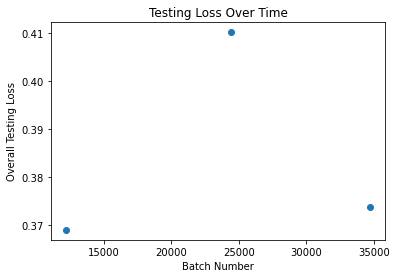

In [28]:
weight_fnames = os.listdir('./saved_weights4/')
#weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights4/{fname}', map_location=device)
    
    # network weights load
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 1024),
               nn.BatchNorm1d(1024),
               nn.ReLU(),
               nn.Dropout(p=0.4),
               nn.Linear(1024, 256),
               nn.BatchNorm1d(256),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(256, 1),
               nn.Sigmoid()).to(device)

    net.load_state_dict(checkpoint['model_state_dict'])  
    criterion = nn.BCELoss()
    
    net.eval()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            outputs = outputs.to("cpu")
            label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 10 == 0:
                print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results4/results_ResNeSt_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

[Batch 12204] Size Area Under the ROC Curve: 0.8258807826056412 

[Batch 24408] Size Area Under the ROC Curve: 0.8511823219575512 

[Batch 34719] Size Area Under the ROC Curve: 0.8660548064812351 



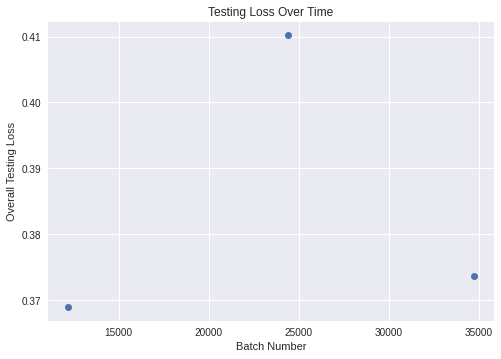

In [30]:
plt.style.use('seaborn')

# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results4/')
    
    for fname in res_fnames:
        with open(f'./saved_results4/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"]) 
            
            
            gt = res["ground_truths"]
            probs = np.array(res["probs"])

            # match formats (shouldve done this before, forgot to check)
            ground_truths = []
            for i in range(len(gt)):
                if gt[i].size() > torch.Size([1]):
                    ground_truths += gt[i].squeeze(-1).tolist()
                else:
                    ground_truths.append(gt[i].squeeze(-1).tolist())

            ground_truths = np.array(ground_truths)
            print(f"[Batch {res['num_batches']}] Size Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [ ]:
best_batch_size = 21350


with open(f'./saved_results4/results_ResNeSt_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()